In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn

In [ ]:
words = open('names.txt','r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [ ]:
chars = sorted(list(set(''.join(words))))
chars

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [ ]:
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [ ]:
block_size = 3

def build_dataset(words):
  X , y = [],[]
  for w in words:
    context = [0]*block_size
    for ch in w+'.':
      ix = stoi[ch]
      X.append(context)
      y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  y = torch.tensor(y)
  print(X.shape,y.shape)
  return X,y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,ytr = build_dataset(words[:n1])
Xdev,ydev = build_dataset(words[n1:n2])
Xte,yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
n_emb = 10
n_hidden = 200
g = torch.Generator().manual_seed(2147483647)
vocab_size = len(itos)
C = torch.randn((vocab_size,n_emb), generator = g)

class NeuralNet(nn.Module):
  def __init__(self,n_emb,n_hidden,vocab_size):
    super().__init__()

    self.n_emb = n_emb
    self.vocab_size = vocab_size
    self.C = C
    self.linear1 = nn.Linear(n_emb*block_size,n_hidden,bias=False)
    self.tanh = nn.Tanh()
    self.linear2 = nn.Linear(n_hidden,n_hidden,bias = False)
    self.linear21 = nn.Linear(n_hidden,n_hidden,bias = False)
    self.linear22 = nn.Linear(n_hidden,n_hidden,bias = False)
    self.linear23 = nn.Linear(n_hidden,n_hidden,bias = False)

    self.linear3 = nn.Linear(n_hidden,vocab_size,bias=False)
    self.batchnorm1d = nn.BatchNorm1d(n_hidden)
    self.batchnorm1d2 = nn.BatchNorm1d(vocab_size)

    for p in self.parameters():
      p.requires_grad = True

  def forward(self,x):
    emb = self.C[x]
    h = self.linear1(emb.view(-1,self.n_emb*block_size))
    h = self.batchnorm1d(h)
    h = self.tanh(h)
    h = self.tanh(self.batchnorm1d(self.linear2(h)))
    h = self.tanh(self.batchnorm1d(self.linear21(h)))
    h = self.tanh(self.batchnorm1d(self.linear22(h)))
    h = self.tanh(self.batchnorm1d(self.linear23(h)))
    h = self.batchnorm1d2(self.linear3(h))*0.1
    return h

In [ ]:
model = NeuralNet(n_emb,n_hidden,vocab_size)
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  # minibatch
  ix = torch.randint(0,Xtr.shape[0],(batch_size,) , generator = g)
  Xb, yb = Xtr[ix],ytr[ix]

  # forward
  y_hat = model(Xb)
  loss = F.cross_entropy(y_hat,yb)

  # backward
  for p in model.parameters():
    p.grad = None
  loss.backward()

  # update
  lr = 0.02 if i < 100000 else 0.002
  for p in model.parameters():
    p.data += -lr* p.grad

  #track
  if i%10000 == 0:
    print(f'i : {i+1}/{max_steps} , loss : {loss.item()}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std()/(p.data).std()).log10().item() for p in model.parameters()])
  if i>1000:
    break

i : 1/200000 , loss : 3.319884777069092


In [ ]:
loss

tensor(3.1895, grad_fn=<NllLossBackward0>)

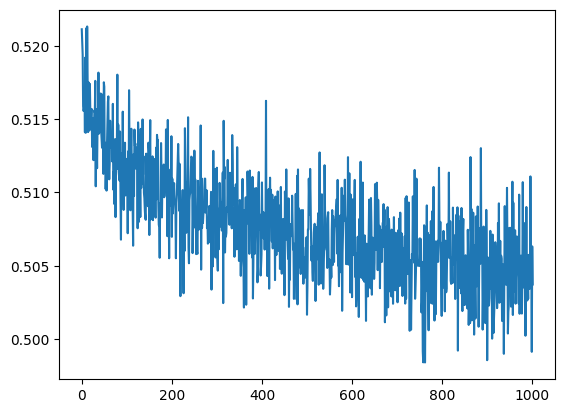

In [ ]:
plt.plot(lossi)

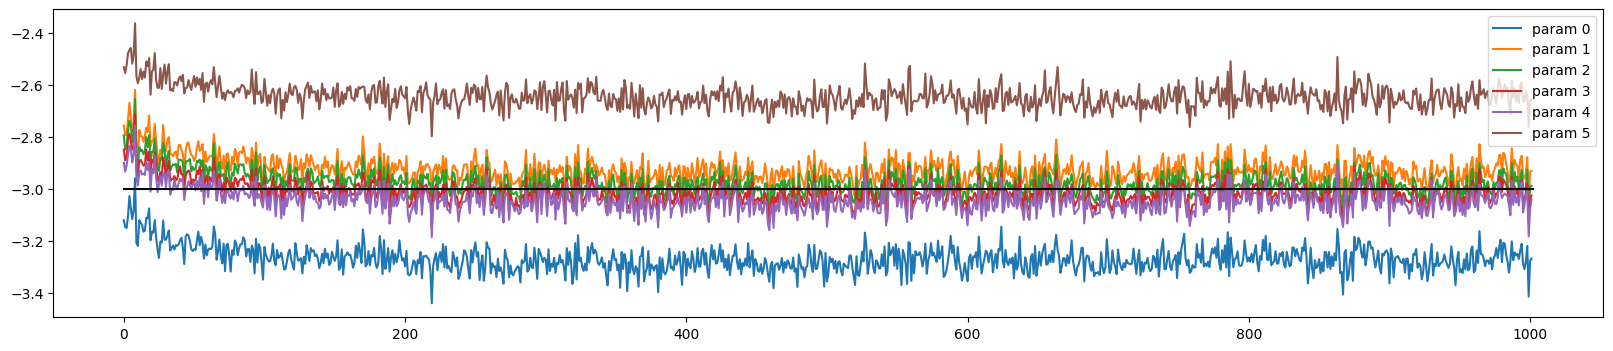

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(model.parameters()):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [ ]:
for i, p in enumerate(model.parameters()):
    print(f"Param {i}: shape {p.shape}, ndim {p.ndim}")


Param 0: shape torch.Size([200, 30]), ndim 2
Param 1: shape torch.Size([200, 200]), ndim 2
Param 2: shape torch.Size([200, 200]), ndim 2
Param 3: shape torch.Size([200, 200]), ndim 2
Param 4: shape torch.Size([200, 200]), ndim 2
Param 5: shape torch.Size([27, 200]), ndim 2
Param 6: shape torch.Size([200]), ndim 1
Param 7: shape torch.Size([200]), ndim 1
Param 8: shape torch.Size([27]), ndim 1
Param 9: shape torch.Size([27]), ndim 1


In [ ]:
class Linear:

  def __init__(self,fan_in,fan_out,bias = True):
    self.weights = torch.randn(fan_in,fan_out,generator=g)/fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self,x):
    self.out = x @ self.weights
    if self.bias is not None:
      self.out+=self.bias
    return self.out

  def parameters(self):
    return [self.weights] + ([] if self.bias is None else [self.bias])


class Tanh:

  def __call__(self,x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []


class BatchNorm1D:

  def __init__(self,dim,eps = 1e-5, momentum = 0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # params (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffer (trained with running momentum update)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self,x):
    if self.training:
      x_mean = x.mean(0,keepdim=True)
      x_var = x.var(0,keepdim=True)
    else:
      x_mean = self.running_mean
      x_var = self.running_var
    x_hat = (x-x_mean)/torch.sqrt(x_var + self.eps)
    self.out = self.gamma * x_hat + self.beta
    with torch.no_grad():
      if self.training:
        self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*x_mean
        self.running_var = (1-self.momentum)*self.running_var + self.momentum*x_var
    return self.out

  def parameters(self):
    return [self.gamma,self.beta]


In [ ]:
n_emb = 10
n_hidden = 200
vocab_size = len(itos)
C = torch.randn((vocab_size,n_emb), generator = g)

layers = [
    Linear(n_emb*block_size,n_hidden,bias =False) , BatchNorm1D(n_hidden), Tanh(),
    Linear(        n_hidden,n_hidden,bias =False) , BatchNorm1D(n_hidden), Tanh(),
    Linear(        n_hidden,n_hidden,bias =False) , BatchNorm1D(n_hidden), Tanh(),
    Linear(        n_hidden,n_hidden,bias =False) , BatchNorm1D(n_hidden), Tanh(),
    Linear(        n_hidden,n_hidden,bias =False) , BatchNorm1D(n_hidden), Tanh(),
    Linear(        n_hidden,vocab_size,bias =False) , BatchNorm1D(vocab_size),
]
with torch.no_grad():
  layers[-1].gamma*=0.1 # making less confident
  # kiming initialization gain
  # for layer in layers:
  #   if isinstance(layer,Linear):
  #     layer.weights*=5/3

parameters = [C]+[p for layer in layers for p in layer.parameters()]
for p in parameters:
  p.requires_grad = True

In [ ]:
max_steps = 200000
batch = 32
lossi = []
ud = []
for i in range(max_steps):
  # mini batch
  ix = torch.randint(0,Xtr.shape[0],(batch,))
  Xb,yb = Xtr[ix],ytr[ix]

  # forward
  emb = C[Xb]
  x = emb.view(-1,n_emb*block_size)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x,yb)

  # backward
  for l in layers:
    l.out.retain_grad()
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.02 if i < 100000 else 0.002
  for p in parameters:
    p.data += -lr*p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i>1000:
    break

      0/ 200000: 3.3015


In [ ]:
loss

tensor(2.6149, grad_fn=<NllLossBackward0>)

# Tools

layer 2 (      Tanh): mean -0.01, std 0.63, saturated: 2.94%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.39%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.27%
layer 11 (      Tanh): mean +0.00, std 0.64, saturated: 2.52%
layer 14 (      Tanh): mean -0.00, std 0.64, saturated: 2.27%


Text(0.5, 1.0, 'activation distribution')

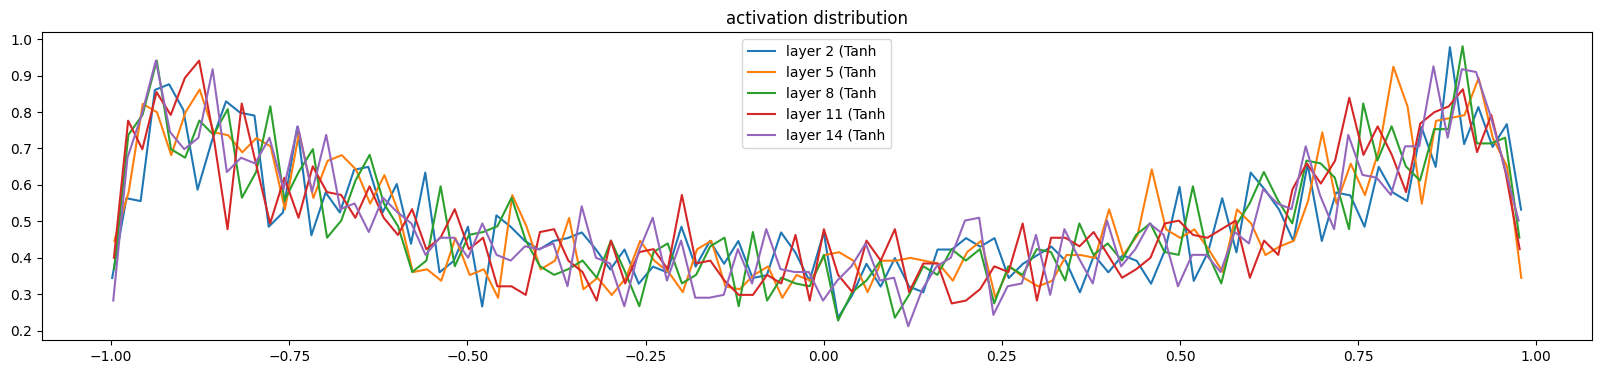

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 1.992163e-03
layer 5 (      Tanh): mean -0.000000, std 1.721320e-03
layer 8 (      Tanh): mean -0.000000, std 1.580706e-03
layer 11 (      Tanh): mean -0.000000, std 1.445954e-03
layer 14 (      Tanh): mean +0.000000, std 1.332354e-03


Text(0.5, 1.0, 'gradient distribution')

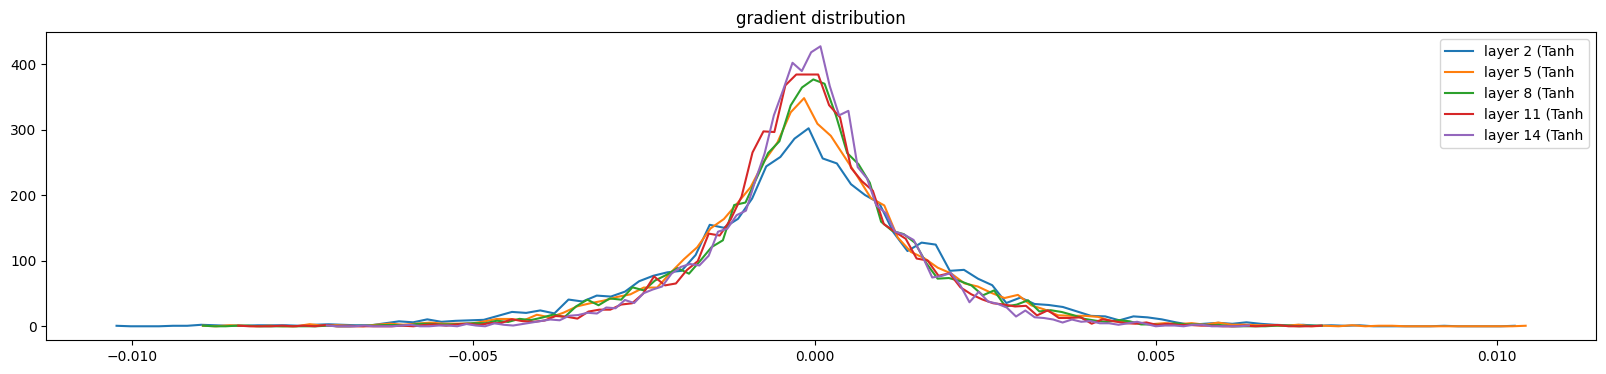

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 7.817945e-03 | grad:data ratio 8.074320e-03
weight  (30, 200) | mean +0.000173 | std 8.106767e-03 | grad:data ratio 4.445355e-02
weight (200, 200) | mean -0.000052 | std 6.743983e-03 | grad:data ratio 9.546676e-02
weight (200, 200) | mean -0.000025 | std 5.853282e-03 | grad:data ratio 8.251247e-02
weight (200, 200) | mean -0.000014 | std 5.371160e-03 | grad:data ratio 7.611147e-02
weight (200, 200) | mean +0.000006 | std 4.752665e-03 | grad:data ratio 6.696839e-02
weight  (200, 27) | mean -0.000092 | std 1.217492e-02 | grad:data ratio 1.726225e-01


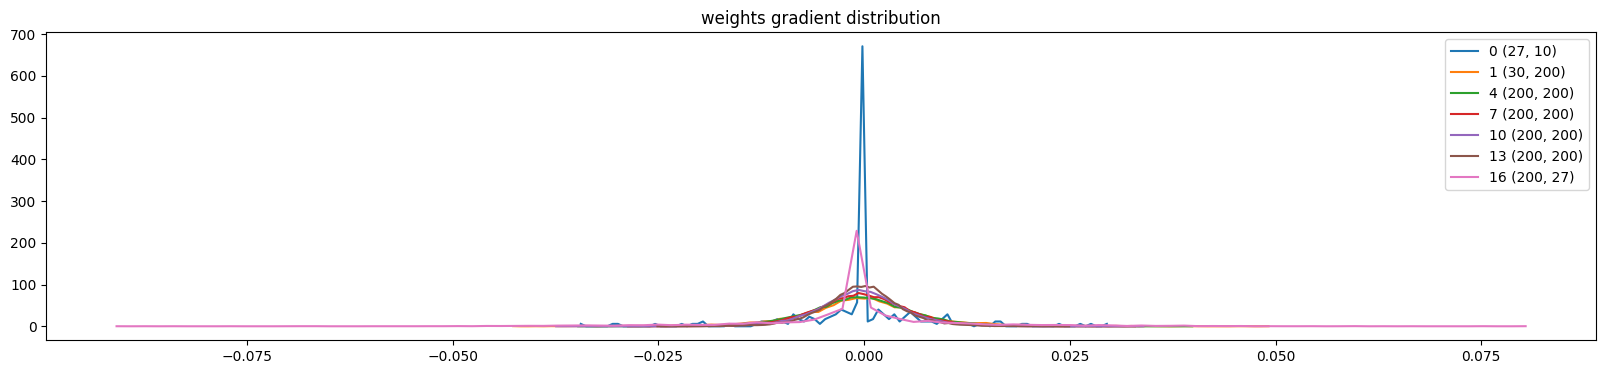

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

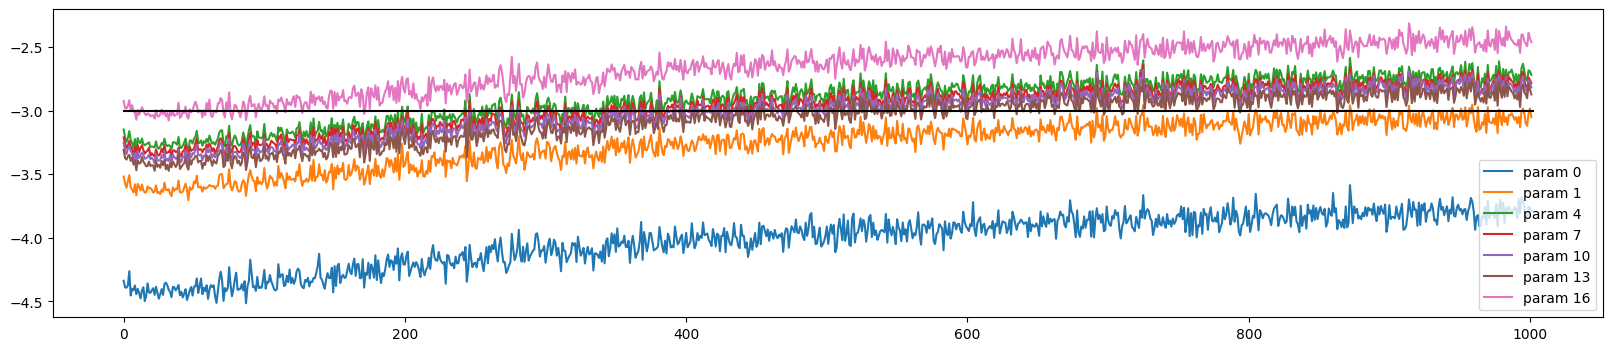

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, ytr),
    'val': (Xdev, ydev),
    'test': (Xte, yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.5555226802825928
val 2.5530898571014404


# zero init does not work

In [ ]:
# initialize with zeros
class Linear:

  def __init__(self,fan_in,fan_out,bias = True):
    self.weights = torch.randn(fan_in,fan_out,generator=g)*0 # zeros
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self,x):
    self.out = x @ self.weights
    if self.bias is not None:
      self.out+=self.bias
    return self.out

  def parameters(self):
    return [self.weights] + ([] if self.bias is None else [self.bias])


class Tanh:

  def __call__(self,x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []


class BatchNorm1D:

  def __init__(self,dim,eps = 1e-5, momentum = 0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # params (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffer (trained with running momentum update)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self,x):
    if self.training:
      x_mean = x.mean(0,keepdim=True)
      x_var = x.var(0,keepdim=True)
    else:
      x_mean = self.running_mean
      x_var = self.running_var
    x_hat = (x-x_mean)/torch.sqrt(x_var + self.eps)
    self.out = self.gamma * x_hat + self.beta
    with torch.no_grad():
      if self.training:
        self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*x_mean
        self.running_var = (1-self.momentum)*self.running_var + self.momentum*x_var
    return self.out

  def parameters(self):
    return [self.gamma,self.beta]


n_emb = 10
n_hidden = 200
vocab_size = len(itos)
C = torch.randn((vocab_size,n_emb), generator = g)

layers = [
    Linear(n_emb*block_size,n_hidden,bias =False) , BatchNorm1D(n_hidden), Tanh(),
    Linear(        n_hidden,n_hidden,bias =False) , BatchNorm1D(n_hidden), Tanh(),
    Linear(        n_hidden,n_hidden,bias =False) , BatchNorm1D(n_hidden), Tanh(),
    Linear(        n_hidden,n_hidden,bias =False) , BatchNorm1D(n_hidden), Tanh(),
    Linear(        n_hidden,n_hidden,bias =False) , BatchNorm1D(n_hidden), Tanh(),
    Linear(        n_hidden,vocab_size,bias =False) , BatchNorm1D(vocab_size),
]
with torch.no_grad():
  layers[-1].gamma*=0.1 # making less confident
  # kiming initialization gain
  # for layer in layers:
  #   if isinstance(layer,Linear):
  #     layer.weights*=5/3

parameters = [C]+[p for layer in layers for p in layer.parameters()]
for p in parameters:
  p.requires_grad = True

In [ ]:
max_steps = 200000
batch = 32
lossi = []
ud = []
for i in range(max_steps):
  # mini batch
  ix = torch.randint(0,Xtr.shape[0],(batch,))
  Xb,yb = Xtr[ix],ytr[ix]

  # forward
  emb = C[Xb]
  x = emb.view(-1,n_emb*block_size)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x,yb)

  # backward
  for l in layers:
    l.out.retain_grad()
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.02 if i < 100000 else 0.002
  for p in parameters:
    p.data += -lr*p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i>1000:
    break

      0/ 200000: 3.2958


layer 2 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

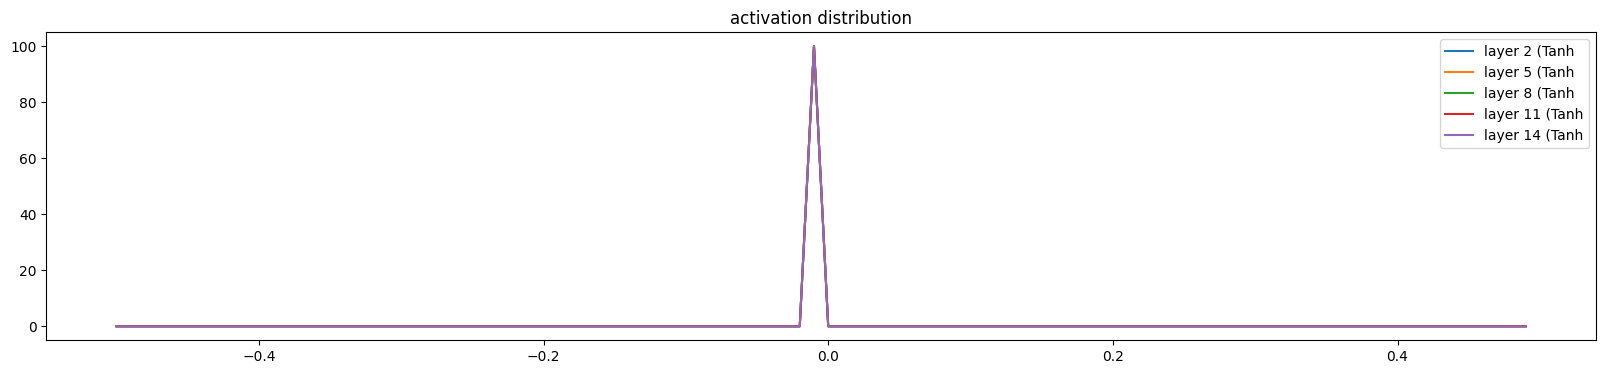

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 0.000000e+00
layer 5 (      Tanh): mean +0.000000, std 0.000000e+00
layer 8 (      Tanh): mean +0.000000, std 0.000000e+00
layer 11 (      Tanh): mean +0.000000, std 0.000000e+00
layer 14 (      Tanh): mean +0.000000, std 0.000000e+00


Text(0.5, 1.0, 'gradient distribution')

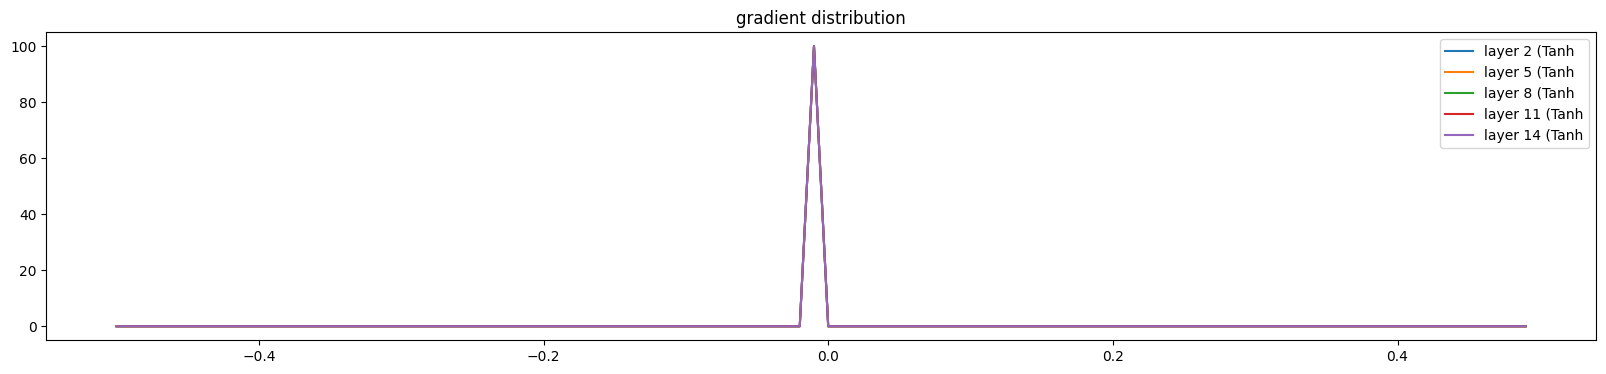

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 0.000000e+00 | grad:data ratio 0.000000e+00
weight  (30, 200) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (200, 200) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (200, 200) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (200, 200) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (200, 200) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight  (200, 27) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan


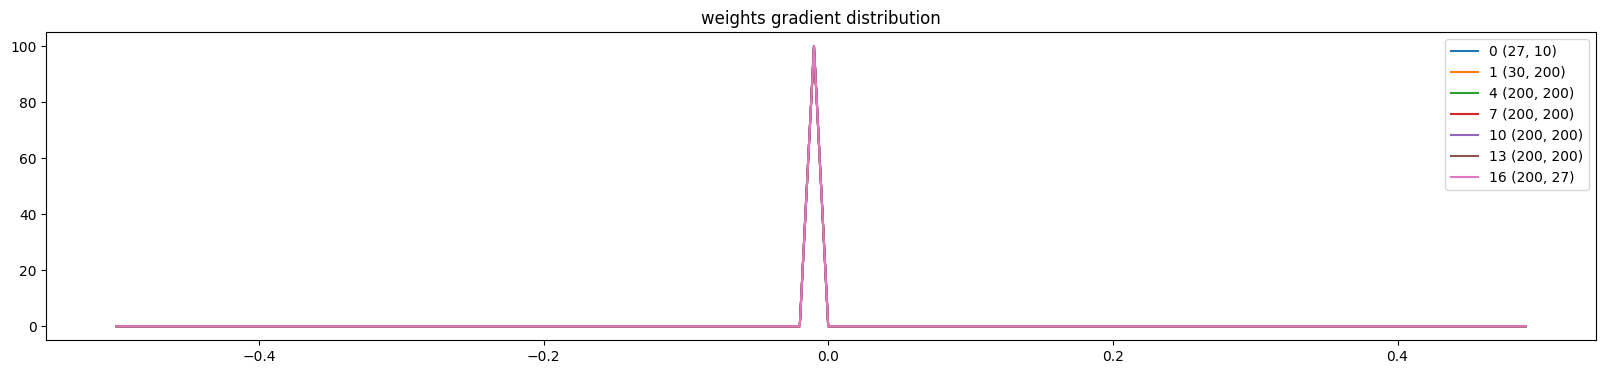

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

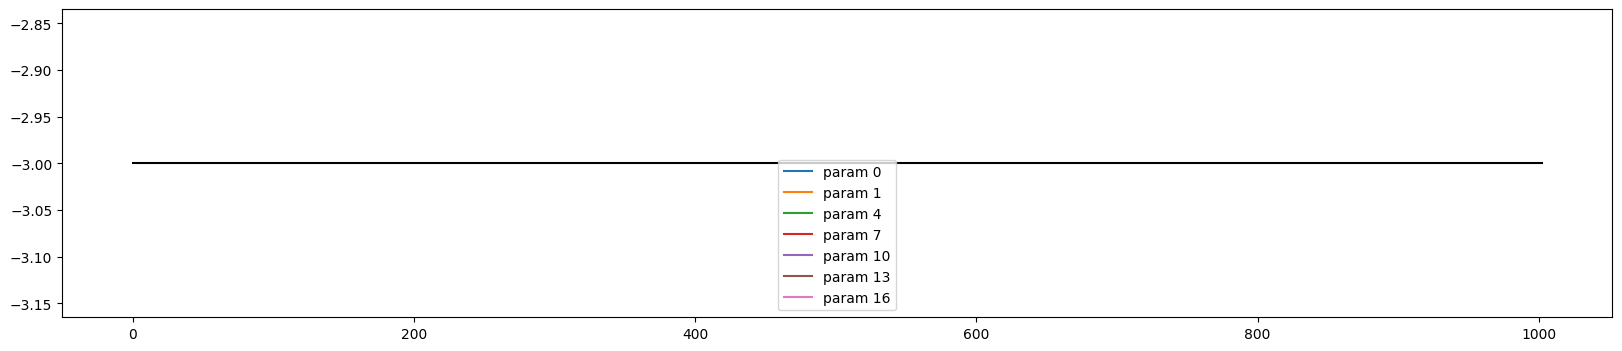

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

# folding batchnorm mean and variance at inference time

In [ ]:
# initialize with zeros
class Linear:

  def __init__(self,fan_in,fan_out,bias = True):
    self.weights = torch.randn(fan_in,fan_out,generator=g)
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self,x):
    self.out = x @ self.weights
    if self.bias is not None:
      self.out+=self.bias
    return self.out

  def parameters(self):
    return [self.weights] + ([] if self.bias is None else [self.bias])


class Tanh:

  def __call__(self,x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []


class BatchNorm1D:

  def __init__(self,dim,eps = 1e-5, momentum = 0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # params (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffer (trained with running momentum update)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self,x):
    if self.training:
      x_mean = x.mean(0,keepdim=True)
      x_var = x.var(0,keepdim=True)
    else:
      x_mean = self.running_mean
      x_var = self.running_var
    x_hat = (x-x_mean)/torch.sqrt(x_var + self.eps)
    self.out = self.gamma * x_hat + self.beta
    with torch.no_grad():
      if self.training:
        self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*x_mean
        self.running_var = (1-self.momentum)*self.running_var + self.momentum*x_var
    return self.out

  def parameters(self):
    return [self.gamma,self.beta]


n_emb = 10
n_hidden = 200
vocab_size = len(itos)
C = torch.randn((vocab_size,n_emb), generator = g)

layers = [
    Linear(n_emb*block_size,n_hidden,bias =False) , BatchNorm1D(n_hidden), Tanh(),
    Linear(        n_hidden,n_hidden,bias =False) , BatchNorm1D(n_hidden), Tanh(),
    Linear(        n_hidden,vocab_size,bias =False) , BatchNorm1D(vocab_size),
]
with torch.no_grad():
  layers[-1].gamma*=0.1 # making less confident
  # kiming initialization gain
  # for layer in layers:
  #   if isinstance(layer,Linear):
  #     layer.weights*=5/3

parameters = [C]+[p for layer in layers for p in layer.parameters()]
for p in parameters:
  p.requires_grad = True

In [ ]:
max_steps = 200000
batch = 32
lossi = []
ud = []
for i in range(max_steps):
  # mini batch
  ix = torch.randint(0,Xtr.shape[0],(batch,))
  Xb,yb = Xtr[ix],ytr[ix]

  # forward
  emb = C[Xb]
  x = emb.view(-1,n_emb*block_size)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x,yb)

  # backward
  for l in layers:
    l.out.retain_grad()
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.02 if i < 100000 else 0.002 # adjust
  for p in parameters:
    p.data += -lr*p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  # if i>1000:
  #   break

      0/ 200000: 3.2724
  10000/ 200000: 2.5233
  20000/ 200000: 2.7536
  30000/ 200000: 2.3017
  40000/ 200000: 2.4952
  50000/ 200000: 2.3151
  60000/ 200000: 2.3837
  70000/ 200000: 2.4572
  80000/ 200000: 2.0297
  90000/ 200000: 2.2413
 100000/ 200000: 2.2653
 110000/ 200000: 2.1927
 120000/ 200000: 2.0781
 130000/ 200000: 2.1242
 140000/ 200000: 1.8155
 150000/ 200000: 2.3414
 160000/ 200000: 2.7781
 170000/ 200000: 2.2832
 180000/ 200000: 2.3711
 190000/ 200000: 2.1662


In [ ]:
loss

tensor(2.0646, grad_fn=<NllLossBackward0>)

In [ ]:
# https://pub.towardsai.net/initialization-batchnorm-and-layernorm-beyond-textbook-definitions-9306b02c7e9a

In [ ]:
# linear -> wx -> gamma*((wx - mean)/std) + beta
@torch.no_grad()
def fold(linear:Linear,bn:BatchNorm1D):
  running_mean = bn.running_mean
  running_var = bn.running_var
  beta = bn.beta
  gamma = bn.gamma
  eps = bn.eps
  w = linear.weights


  folded_w = (w * gamma) / (running_var + eps)**0.5
  folded_bias = beta - (running_mean)* gamma / (running_var + eps)**0.5

  new_linear = Linear(w.shape[0],w.shape[1],bias = True)
  new_linear.weights = folded_w
  new_linear.bias = folded_bias
  return new_linear

In [ ]:
l = fold(layers[0],layers[1])

In [ ]:
l.weights

tensor([[ 0.2125, -0.0150, -0.1803,  ...,  0.0927,  0.0544, -0.1725],
        [ 0.2497,  0.1388, -0.0969,  ..., -0.0672,  0.0078, -0.2011],
        [-0.1217,  0.0168,  0.1831,  ...,  0.0138,  0.0647, -0.0831],
        ...,
        [-0.2557,  0.3117, -0.0870,  ..., -0.0426,  0.1094,  0.4090],
        [-0.0552, -0.2850, -0.1632,  ..., -0.0290, -0.0172, -0.2191],
        [-0.0367,  0.3573, -0.0791,  ...,  0.0627, -0.0118,  0.0406]])

In [ ]:
for layer in layers:
    if isinstance(layer, BatchNorm1D):
        layer.training = False

new_layers = []
i = 0
while i<len(layers):
  if isinstance(layers[i],Linear) and isinstance(layers[i+1],BatchNorm1D):
    new_layers.append(fold(layers[i],layers[i+1]))
    # print(layers[i].__class__,layers[i+1].__class__)
    i+=2
  else:
    new_layers.append(layers[i])
    # print(layers[i].__class__)
    i+=1

In [ ]:
# folded
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, ytr),
    'val': (Xdev, ydev),
    'test': (Xte, yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in new_layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.2835044860839844
val 2.2844245433807373


In [ ]:
# without folded
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, ytr),
    'val': (Xdev, ydev),
    'test': (Xte, yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.2835044860839844
val 2.2844245433807373


In [ ]:
# for i, layer in enumerate(new_layers):
#     print(i, type(layer))

0 <class '__main__.Linear'>
1 <class '__main__.Tanh'>
2 <class '__main__.Linear'>
3 <class '__main__.Tanh'>
4 <class '__main__.Linear'>


In [ ]:
# inference
for _ in range(20):
  out = []
  context = [0]*block_size
  while True:
    emb = C[torch.tensor(context)].view(-1,n_emb*block_size)
    x = emb
    for layer in layers:
      x = layer(x)
    logits = x
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))

guma.
noh.
basar.
marrnin.
konetst.
anottafina.
thansoned.
sandamaij.
bree.
kyeni.
carthc.
mar.
xhiphaen.
kylie.
nie.
armynl.
ziorlon.
alande.
amlaszuriak.
zijleehf.


In [4]:
# BatchNorm forward pass as a widget
import torch
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

def normshow(x0):

  g = torch.Generator().manual_seed(2147483647+1)
  x = torch.randn(5, generator=g) * 5
  x[0] = x0 # override the 0th example with the slider
  mu = x.mean()
  sig = x.std()
  y = (x - mu)/sig

  plt.figure(figsize=(10, 5))
  # plot 0
  plt.plot([-6,6], [0,0], 'k')
  # plot the mean and std
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b')
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')
  # plot little lines connecting input and output
  for i in range(len(x)):
    plt.plot([x[i],y[i]], [1, 0], 'k', alpha=0.2)
  # plot the input and output values
  plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)
  plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100)
  plt.xlim(-6, 6)
  # title
  plt.title('input mu %.2f std %.2f' % (mu, sig))

interact(normshow, x0=(-30,30,0.2));

interactive(children=(FloatSlider(value=0.0, description='x0', max=30.0, min=-30.0, step=0.2), Output()), _dom…

In [5]:
# Linear: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000,1), requires_grad=True, generator=g)          # a.grad = b.T @ c.grad
b = torch.randn((1000,1000), requires_grad=True, generator=g)       # b.grad = c.grad @ a.T
c = b @ a
loss = torch.randn(1000, generator=g) @ c
a.retain_grad()
b.retain_grad()
c.retain_grad()
loss.backward()
print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item())
print('-----')
print('c grad std:', c.grad.std().item())
print('a grad std:', a.grad.std().item())
print('b grad std:', b.grad.std().item())

a std: 0.9875972270965576
b std: 1.0006722211837769
c std: 31.01241683959961
-----
c grad std: 0.9782556295394897
a grad std: 30.8818302154541
b grad std: 0.9666601419448853


In [6]:
# Linear + BatchNorm: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

n = 1000
# linear layer ---
inp = torch.randn(n, requires_grad=True, generator=g)
w = torch.randn((n, n), requires_grad=True, generator=g) # / n**0.5
x = w @ inp
# bn layer ---
xmean = x.mean()
xvar = x.var()
out = (x - xmean) / torch.sqrt(xvar + 1e-5)
# ----
loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print('inp std: ', inp.std().item())
print('w std: ', w.std().item())
print('x std: ', x.std().item())
print('out std: ', out.std().item())
print('------')
print('out grad std: ', out.grad.std().item())
print('x grad std: ', x.grad.std().item())
print('w grad std: ', w.grad.std().item())
print('inp grad std: ', inp.grad.std().item())

inp std:  0.9875972270965576
w std:  1.0006722211837769
x std:  31.01241683959961
out std:  1.0
------
out grad std:  0.9782556295394897
x grad std:  0.031543977558612823
w grad std:  0.031169468536973
inp grad std:  0.9953053593635559
